## This notebook uses the output of Esmeralda to show the beautiful things that can be done with it

In [1]:
%matplotlib inline

import os
import sys
import random
import tables as tb
import numpy  as np
import pandas as pd

import matplotlib.pyplot as plt

import invisible_cities.core.fit_functions     as fitf
from   invisible_cities.core.stat_functions    import poisson_sigma
from   invisible_cities.core.system_of_units_c import units

from   invisible_cities.icaro.hst_functions import hist, gausstext, labels

In [2]:
### Useful parameters for plots
plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = 13, 11
plt.rcParams['figure.max_open_warning']= 0

## Color definition
def get_color(r, g, b):
    return (r / 255., g / 255., b / 255.)

fucsia     = get_color(218, 60, 78)
light_blue = get_color(35, 180, 203)
orange     = get_color(255, 127, 14)
pink       = get_color(255, 152, 150)
green      = get_color(44, 160, 44)
brown      = get_color(140, 86, 75)

### Some useful functions

In [3]:
def exp(x, a0, tau):
    return a0 * np.exp(x/tau)

def gauss(x, amp, mu, sigma):
    return amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)

def expgauss(x, a0, tau, amp, mu, sigma):
    return a0 * np.exp(x/tau) + amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)

In [4]:
def fiducialize_df(tracks_df, summary_df, rmax, zmin, zmax):
    
    fid_evt_sel  = (summary_df.r_max < rmax) & (summary_df.z_min > zmin) & (summary_df.z_max < zmax)
    fid_evts     = summary_df[fid_evt_sel]
    fid_trks_sel = tracks_df.event.isin(fid_evts.event.values)
    fid_trks     = tracks_df[fid_trks_sel]
    
    return fid_trks

In [5]:
def one_s2_cut(tracks_df, summary_df):
    
    sel_evts = summary_df[summary_df.nS2 == 1]
    oneS2_trks_sel = tracks_df.event.isin(sel_evts.event.values)
    oneS2_trks = tracks_df[oneS2_trks_sel]
    
    return oneS2_trks
    

### Upload the data : 
### Esmeralda outputs corrected hits, tracks and summary tables. Here we extract only tracks and summary tables for one data run, that were previously been merged into one dataframe ###

In [7]:
file_name = os.path.expandvars('$ESMERALDA')+'/merged_dfs.h5'
tracks  = pd.read_hdf(file_name, 'tracks')
summary = pd.read_hdf(file_name, 'summary')

In [8]:
tracks = tracks.sort_values(by=['event', 'trackID'])
summary = summary.sort_values(by=['event'])

### Parameters for fiducialization

In [9]:
r_max = 180 * units.mm
z_min =  20 * units.mm
z_max = 510 * units.mm

## Extract the energy scale from Cs photopeak and Tl double escape peak and photopeak

In [10]:
e_keV = [662, 1593, 2615]
e_Kr_keV  = [0, 0, 0]

### First cut: fiducialization

In [11]:
fid = fiducialize_df(tracks, summary, r_max, z_min, z_max)

### Second cut: single track

In [12]:
one_track = fid[fid.numb_of_tracks == 1]

### Energy histograms

Text(0, 0.5, 'Counts/bin')

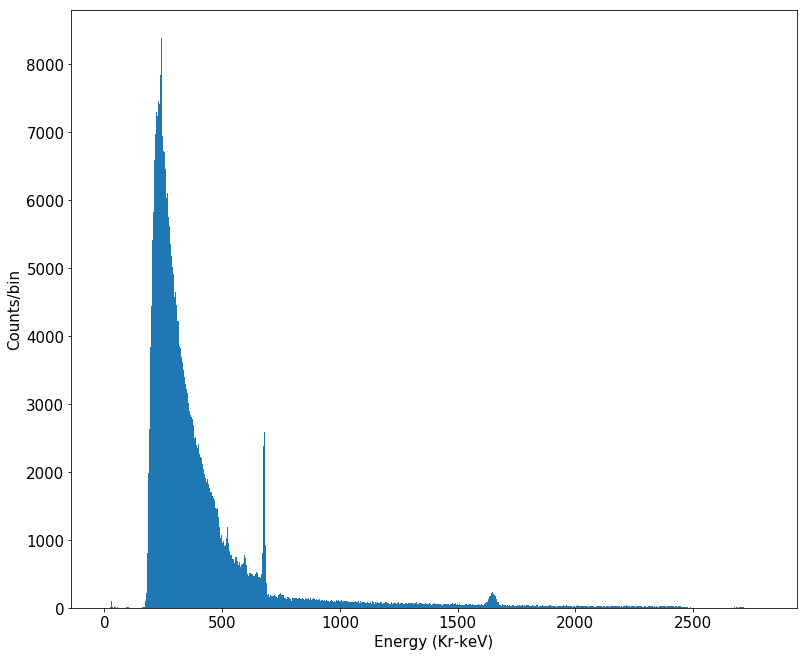

In [13]:
bins_e = 1000
h1 = plt.hist(one_track.energy/units.keV, bins=bins_e, range=(0, 2800))
plt.xlabel('Energy (Kr-keV)')
plt.ylabel('Counts/bin')


Text(0, 0.5, 'Counts/bin')

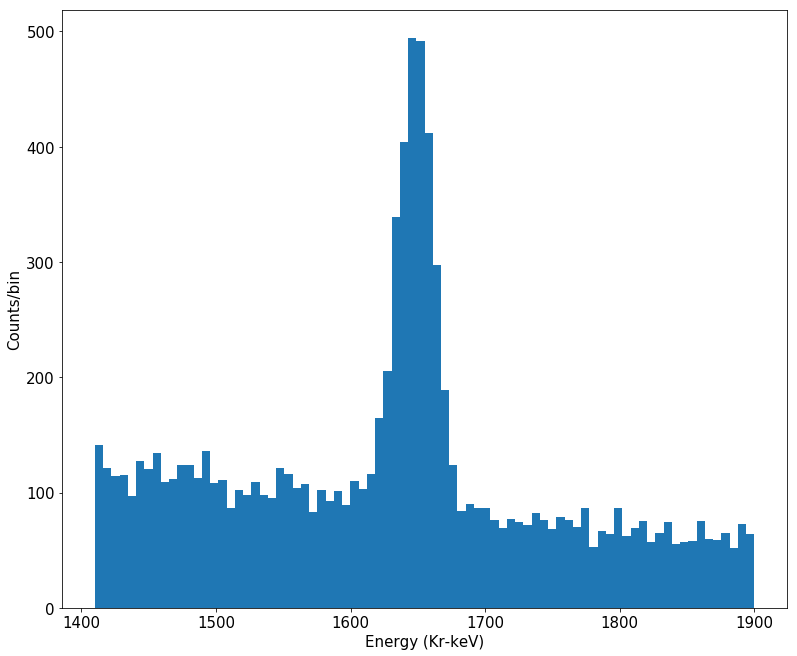

In [14]:
bins_e = 80
h2 = plt.hist(one_track.energy/units.keV, bins=bins_e, range=(1410, 1900))
plt.xlabel('Energy (Kr-keV)')
plt.ylabel('Counts/bin')

Parameters values: [1.79804839e+04 6.78093669e+02 4.53117789e+00]
Parameters errors: [2.44792862e+02 6.59620403e-02 8.47403547e-02]
Chi2/ndf = 3.5986487369220557


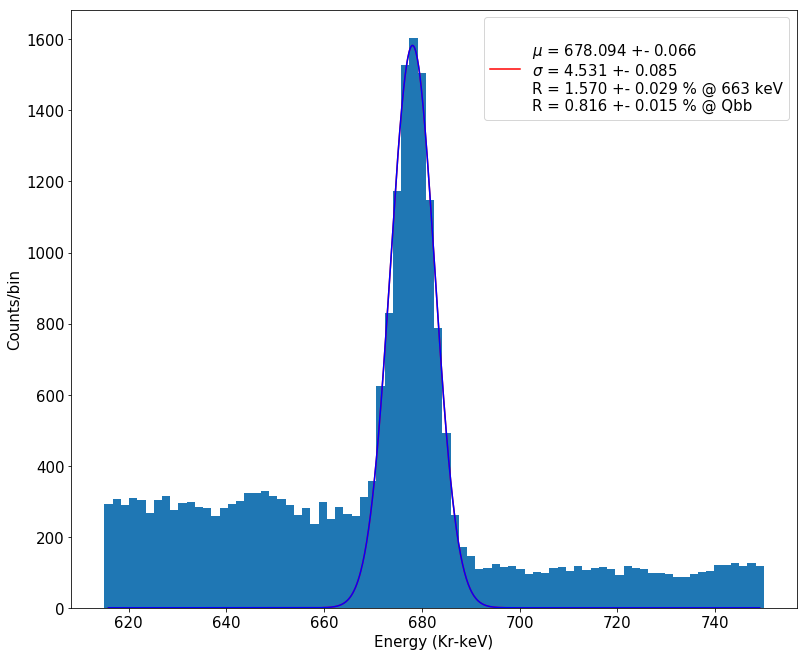

In [15]:
bins_e = 80
    
y, x, _ = hist(one_track.energy/units.keV, bins=bins_e, range=(615, 750))
plt.xlabel('Energy (Kr-keV)')
plt.ylabel('Counts/bin')

fit = True

if fit:
    
    seed = 30, 680, 5
    sigma = poisson_sigma(y)
    f = fitf.fit(fitf.gauss, x, y, seed, fit_range=(670, 685), sigma=sigma)
    print('Parameters values: {}'.format(f.values))
    print('Parameters errors: {}'.format(f.errors))
    print('Chi2/ndf = {}'.format(f.chi2))
    legend = gausstext(f.values[:], f.errors[:], 663, 2458)
    xmin = min(x)
    xmax = max(x)
    mx = np.linspace(xmin, xmax, 1000)
    plt.plot(mx, f.fn(mx), 'r-', label=legend)
    plt.legend(loc=1)

    plt.plot(mx, fitf.gauss(mx, f.values[0], f.values[1], f.values[2]), 'b-', label=legend)
    
    e_Kr_keV[0] = f.values[1]

[ 1031.45726548  -636.37160657 12635.14436959  1648.20649455
    13.49346761]
[297.92583126  71.47310968 336.52339307   0.38635152   0.35109174]
Chi2/ndf = 1.0739980044094701


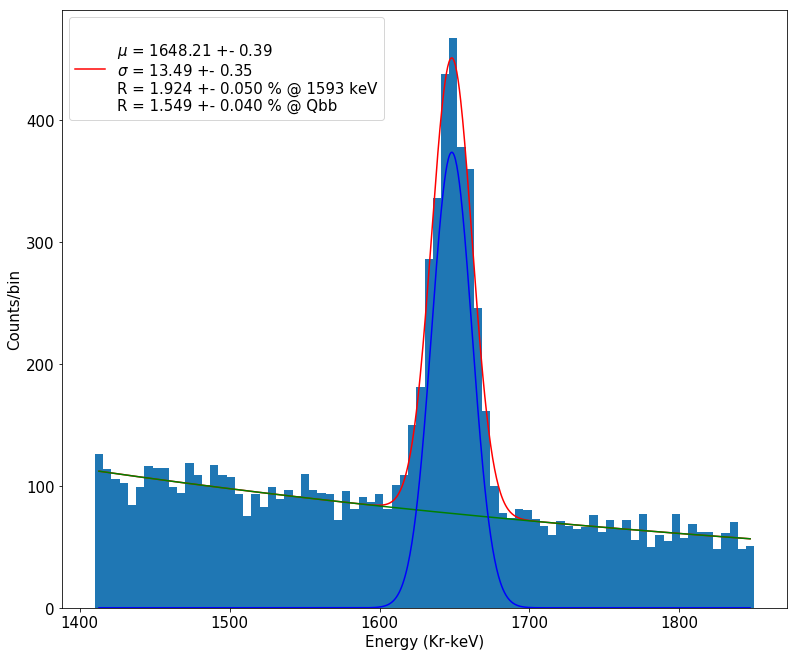

In [16]:
y, x, _ = hist(one_track.energy/units.keV, bins=bins_e, range=(1410, 1850))
plt.xlabel('Energy (Kr-keV)')
plt.ylabel('Counts/bin')

fit = True

if fit:
    
#    seed = 11000, -70000, 100, 470000, 500
    seed = 15, -445, 3300, 1650, 18
    sigma = poisson_sigma(y)
    f     = fitf.fit(expgauss, x, y, seed, fit_range=(1500, 1800), sigma=sigma)
    print(f.values)
    print(f.errors)
    print('Chi2/ndf = {}'.format(f.chi2))
    legend = gausstext(f.values[2:], f.errors[2:], 1593, 2458)
    xmin = min(x)
    xmax = max(x)
    mx = np.linspace(xmin, xmax, 1000)
    plt.plot(mx, f.fn(mx), 'r-', label=legend)
    plt.legend(loc=2)

    plt.plot(mx, exp(mx, f.values[0], f.values[1]), 'g-', label=legend)
    plt.plot(mx, gauss(mx, f.values[2], f.values[3], f.values[4]), 'b-', label=legend)
    
    e_Kr_keV[1] = f.values[3]

[1801.98215929 2702.73293134   23.35866629]
[153.97407083   2.1784686    2.22905067]
Chi2/ndf = 1.3086460235759128


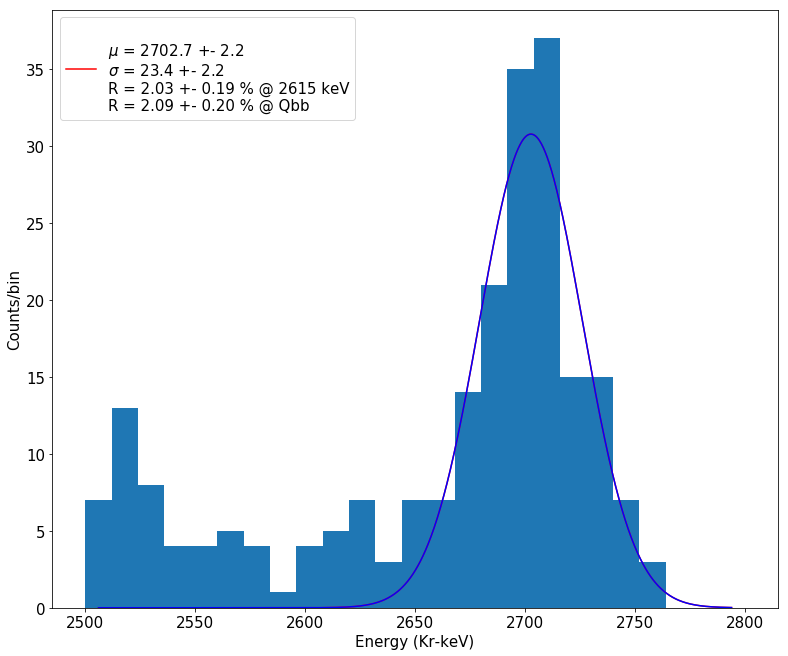

In [17]:
y, x, _ = hist(one_track.energy/units.keV, bins=25, range=(2500, 2800))
plt.xlabel('Energy (Kr-keV)')
plt.ylabel('Counts/bin')

fit = True

if fit:
    
    seed = 1000, 2700, 50
    sigma = poisson_sigma(y)
    f = fitf.fit(gauss, x, y, seed, fit_range=(2660, 2750), sigma=sigma)
    print(f.values)
    print(f.errors)
    print('Chi2/ndf = {}'.format(f.chi2))
    legend = gausstext(f.values[:], f.errors[:], 2615, 2458)
    xmin = min(x)
    xmax = max(x)
    mx = np.linspace(xmin, xmax, 1000)
    plt.plot(mx, f.fn(mx), 'r-', label=legend)
    plt.legend(loc=2)

    plt.plot(mx, gauss(mx, f.values[0], f.values[1], f.values[2]), 'b-', label=legend)
    
    e_Kr_keV[2] = f.values[1]

In [18]:
e_keV    = np.array(e_keV)
e_Kr_keV = np.array(e_Kr_keV)
print(e_keV, e_Kr_keV)

[ 662 1593 2615] [ 678.09366864 1648.20649455 2702.73293134]


### Interpolate with a second grade polynomial passing by the 3 points

In [19]:
x0 = e_Kr_keV[0]
x1 = e_Kr_keV[1]
x2 = e_Kr_keV[2]
y0 = e_keV[0]
y1 = e_keV[1]
y2 = e_keV[2]
print(x0, x1, x2, y0, y1, y2)

678.0936686448143 1648.206494549822 2702.7329313389487 662 1593 2615


In [20]:
# y = a0 + a1*x + a2*x**2
a2 = (y2-y0-(y1-y0)/(x1-x0)*(x2-x0)) / (x2**2-x0**2-(x1**2-x0**2)*(x2-x0)/(x1-x0))
a1 = (y1-y0-a2*(x1**2-x0**2))/(x1-x0)
a0 = y0-a1*x0-a2*x0**2
print(a0, a1, a2)

16.474977057706493 0.9487975070500577 4.678966957978592e-06


(600, 2800)

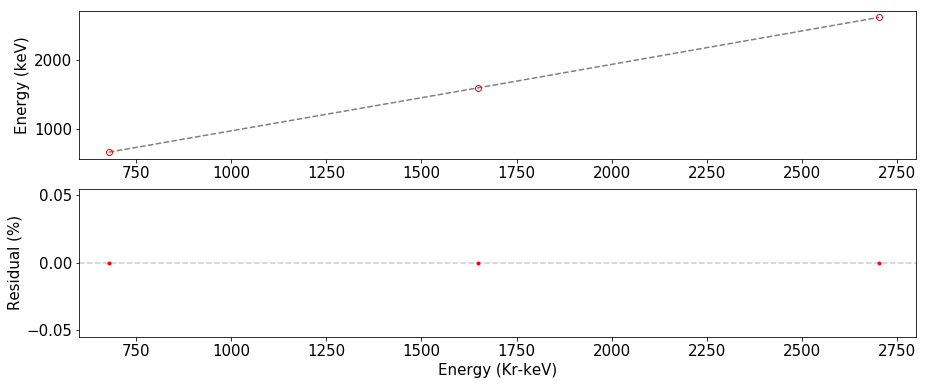

In [21]:
from   matplotlib   import gridspec

def Kr2keV_poly(k):
    return a0 + a1*k + a2*k*k

residuals = 100*(e_keV - Kr2keV_poly(e_Kr_keV)) / e_keV

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)
gs = gridspec.GridSpec(2, 1, height_ratios=[1,1]) 

ax1 = fig.add_subplot(gs[0])
ax1.plot(e_Kr_keV, Kr2keV_poly(e_Kr_keV), '--', color='gray')
ax1.plot(e_Kr_keV, e_keV, '.', markerfacecolor='none', markersize=12, color='red')

ax1.set_ylabel('Energy (keV)')
ax1.set_xlim(600, 2800)

ax2 = fig.add_subplot(gs[1])
ax2.plot(e_Kr_keV, residuals, '.', markersize=6, color='red')
ax2.hlines(0.0,xmin=600.,xmax=2800,linestyle='--',color='gray',alpha=0.4)
ax2.set_xlabel('Energy (Kr-keV)')
ax2.set_ylabel('Residual (%)')
ax2.set_xlim(600, 2800)

## Energy-calibrated plots

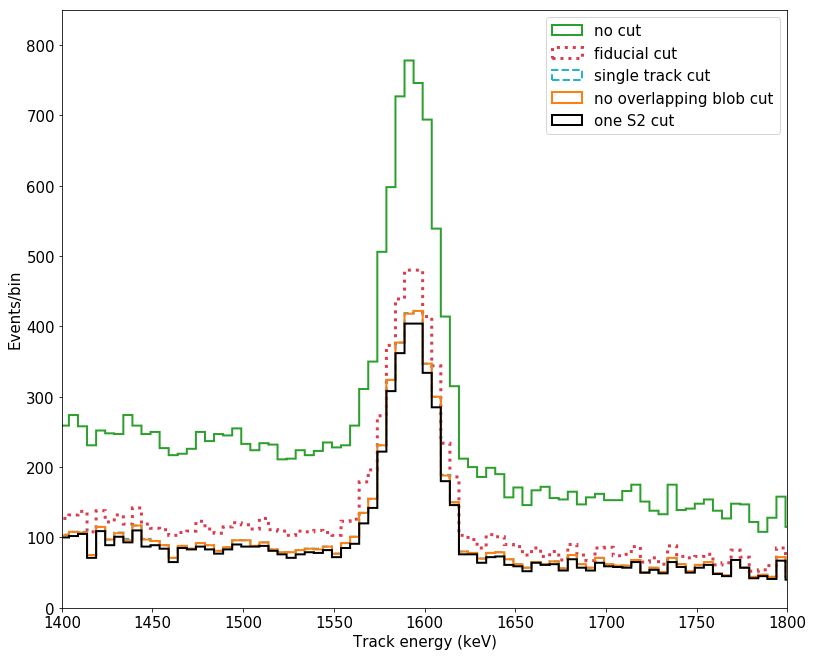

In [22]:
e_min_plot = 1400
e_max_plot = 1800

energy_start  = Kr2keV_poly(tracks.energy/units.keV)
energy_fid    = Kr2keV_poly(fid.energy/units.keV)
energy_single = Kr2keV_poly(one_track.energy/units.keV)
nbins = int((energy_start.max() - energy_start.min())/5)

sep = one_track[np.isclose(one_track.ovlp_blob_energy, 0)]
energy_sep = Kr2keV_poly(sep.energy/units.keV)

oneS2 = one_s2_cut(sep, summary)
energy_oneS2 = Kr2keV_poly(oneS2.energy/units.keV)

bins = np.histogram(np.hstack((energy_start, energy_fid, energy_single, energy_sep)),
                    bins=nbins)[1] # get the bin edges

plt.hist(energy_start,  label='no cut', color=green,
         bins=bins, histtype='step', stacked=True, fill=False, linewidth=2.0)
plt.hist(energy_fid,    label='fiducial cut', color=fucsia,
         bins=bins, histtype='step', stacked=True, fill=False, linewidth=3.0, linestyle=':')
plt.hist(energy_single, label='single track cut', color=light_blue,
         bins=bins, histtype='step', stacked=True, fill=False, linewidth=2.0, linestyle='--')
plt.hist(energy_sep, label='no overlapping blob cut', color=orange,
         bins=bins, histtype='step', stacked=True, fill=False, linewidth=2.0, linestyle='-')
plt.hist(energy_oneS2, label='one S2 cut', color='k',
         bins=bins, histtype='step', stacked=True, fill=False, linewidth=2.0, linestyle='-')

lnd = plt.legend(loc=1)
plt.xlim([1400, 1800])
plt.ylim([0, 850])
#plt.ylim([0, 0.0008])
labels('Track energy (keV)', 'Events/bin', '')

In [23]:
### Here let's apply first the ROI energy cut, to extract cut efficiencies only in the region of the peak.
e_min = 1570
e_max = 1615
roi_sel = (Kr2keV_poly(tracks.energy/units.keV) > e_min) & (Kr2keV_poly(tracks.energy/units.keV) < e_max)
roi = tracks[roi_sel]
fid_roi = fiducialize_df(roi, summary, r_max, z_min, z_max)
single_tr_roi = fid_roi[fid_roi.numb_of_tracks == 1]
sep_roi = single_tr_roi[np.isclose(single_tr_roi.ovlp_blob_energy, 0)]

oneS2_roi = one_s2_cut(sep_roi, summary)

track_energy = Kr2keV_poly(oneS2_roi.energy/units.keV)
e_blob1 = oneS2_roi.eblob1 * Kr2keV_poly(oneS2_roi.energy/units.keV) / oneS2_roi.energy
e_blob2 = oneS2_roi.eblob2 * Kr2keV_poly(oneS2_roi.energy/units.keV) / oneS2_roi.energy
length  = oneS2_roi.length

print('Total number of events: {0}'.format(tracks.event.nunique()))
print('Fraction of events with at least 1 track in {0}-{1} keV: {2}'.format(e_min, e_max, roi.event.nunique()/tracks.event.nunique()))
print('Fraction of events within fiducial: {}'.format(fid_roi.event.nunique()/roi.event.nunique()))
print('Fraction of events with one track: {}'.format(len(single_tr_roi)/fid_roi.event.nunique()))
print('Fraction of tracks with no overlapping blobs: {}'.format(len(sep_roi)/len(single_tr_roi)))
print('Fraction of tracks with one S2: {}'.format(len(oneS2_roi)/len(sep_roi)))

Total number of events: 837758
Fraction of events with at least 1 track in 1570-1615 keV: 0.006396835362956844
Fraction of events within fiducial: 0.6042172047023698
Fraction of events with one track: 0.8542310067943175
Fraction of tracks with no overlapping blobs: 0.9992769342010123
Fraction of tracks with one S2: 0.9576700434153401


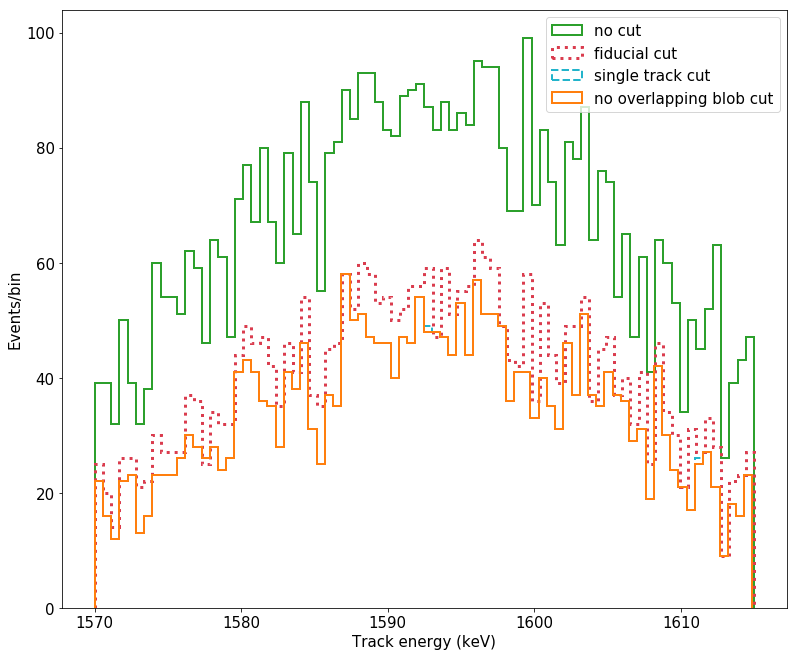

In [24]:
### Check that selecting energy ROI first doesn't change the final result.
e_min_plot = 1400
e_max_plot = 1800
nbins = 80

energy_start_roi  = Kr2keV_poly(roi.energy/units.keV)
energy_fid_roi    = Kr2keV_poly(fid_roi.energy/units.keV)
energy_single_roi = Kr2keV_poly(single_tr_roi.energy/units.keV)
energy_sep_roi    = Kr2keV_poly(sep_roi.energy/units.keV)

plt.hist(energy_start_roi,  label='no cut', color=green,
         bins=nbins, histtype='step', stacked=True, fill=False, linewidth=2.0)
plt.hist(energy_fid_roi,    label='fiducial cut', color=fucsia,
         bins=nbins, histtype='step', stacked=True, fill=False, linewidth=3.0, linestyle=':')
plt.hist(energy_single_roi, label='single track cut', color=light_blue,
         bins=nbins, histtype='step', stacked=True, fill=False, linewidth=2.0, linestyle='--')
plt.hist(energy_sep_roi, label='no overlapping blob cut', color=orange,
         bins=nbins, histtype='step', stacked=True, fill=False, linewidth=2.0, linestyle='-')

lnd = plt.legend(loc=1)
#plt.xlim([1400, 1800])
#plt.ylim([0, 800])
#plt.ylim([0, 0.0008])
labels('Track energy (keV)', 'Events/bin', '')

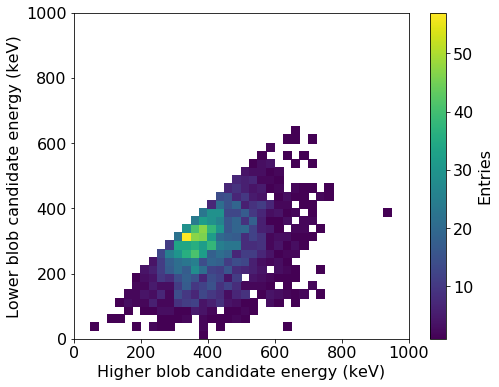

In [25]:
fig = plt.figure(1);
fig.set_figwidth(7.5);
fig.set_figheight(6.);

plt.rcParams.update({'font.size': 16})

bins_blobs = 40
range_blobs = 1000
_, _, _, _ = plt.hist2d(e_blob1, e_blob2, bins=bins_blobs, \
                        range=((0, range_blobs), (0, range_blobs)), cmin=1)
plt.xlabel("Higher blob candidate energy (keV)")
plt.ylabel("Lower blob candidate energy (keV)")
plt.colorbar(label='Entries')

Text(0, 0.5, 'Blob 2 energy (keV)')

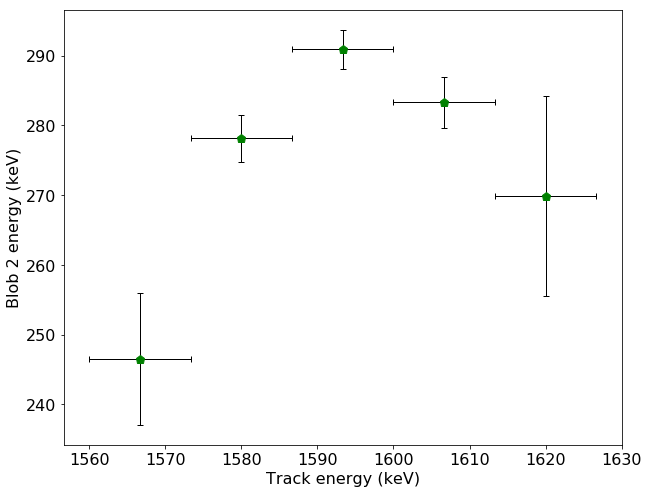

In [26]:
fig = plt.figure(1);
fig.set_figwidth(10.);
fig.set_figheight(8.);

xrange = (1400, 1800)
yrange = (0, 1200)
xbins = 30

x, y, yu = fitf.profileX(track_energy.values, e_blob2.values, xbins, xrange=xrange, drop_nan=False)
plt.errorbar(x, y, yu, np.diff(x)[0]/2, fmt="gp", ms=9, lw=1, ecolor='black', \
             capsize=3)

plt.xlabel('Track energy (keV)')
plt.ylabel('Blob 2 energy (keV)')

Text(0, 0.5, 'Blob 2 energy (keV)')

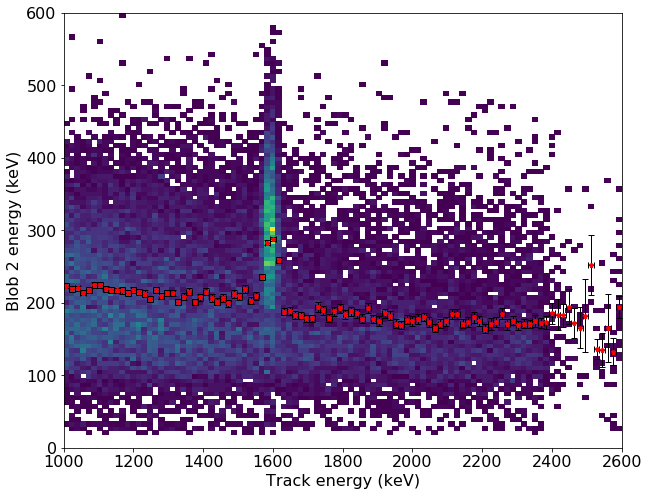

In [27]:
energy_all = Kr2keV_poly(sep.energy/units.keV)
e_blob1_all = sep.eblob1 * Kr2keV_poly(sep.energy/units.keV) / sep.energy
e_blob2_all = sep.eblob2 * Kr2keV_poly(sep.energy/units.keV) / sep.energy


fig = plt.figure(1);
fig.set_figwidth(10.);
fig.set_figheight(8.);

xrange = (1000, 2600)
yrange = (0, 600)
xbins = 100

_, _, _, _ = plt.hist2d(energy_all.values, e_blob2_all.values, bins=(xbins, xbins), \
                        range=(xrange, yrange), cmin=1)

x, y, yu = fitf.profileX(energy_all.values, e_blob2_all.values, xbins, xrange=xrange, drop_nan=False)
plt.errorbar(x, y, yu, np.diff(x)[0]/2, fmt="rp", ms=5, lw=1, ecolor='black', \
             capsize=3);

plt.xlabel('Track energy (keV)')
plt.ylabel('Blob 2 energy (keV)')

Text(0, 0.5, 'Blob 2 energy (keV)')

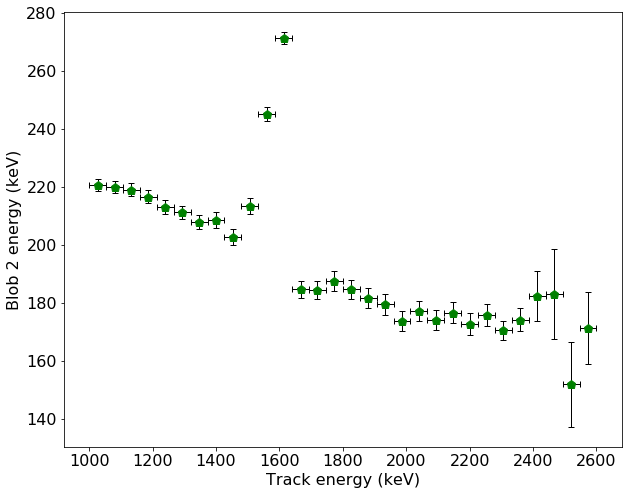

In [28]:
fig = plt.figure(1);
fig.set_figwidth(10.);
fig.set_figheight(8.);

xrange = (1000, 2600)
yrange = (0, 600)
xbins = 30

x, y, yu = fitf.profileX(energy_all, e_blob2_all, xbins, xrange=xrange, drop_nan=False)
plt.errorbar(x, y, yu, np.diff(x)[0]/2, fmt="gp", ms=9, lw=1, ecolor='black', \
             capsize=3)

plt.xlabel('Track energy (keV)')
plt.ylabel('Blob 2 energy (keV)')

Text(0, 0.5, 'Blob 1 energy (keV)')

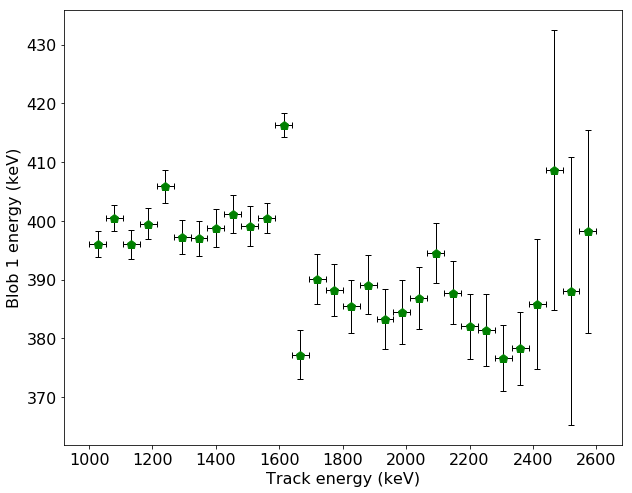

In [29]:
fig = plt.figure(1);
fig.set_figwidth(10.);
fig.set_figheight(8.);

xrange = (1000, 2600)
yrange = (0, 600)
xbins = 30

x, y, yu = fitf.profileX(energy_all, e_blob1_all, xbins, xrange=xrange, drop_nan=False)
plt.errorbar(x, y, yu, np.diff(x)[0]/2, fmt="gp", ms=9, lw=1, ecolor='black', \
             capsize=3)

plt.xlabel('Track energy (keV)')
plt.ylabel('Blob 1 energy (keV)')

Text(0, 0.5, 'Blob 2 energy (keV)')

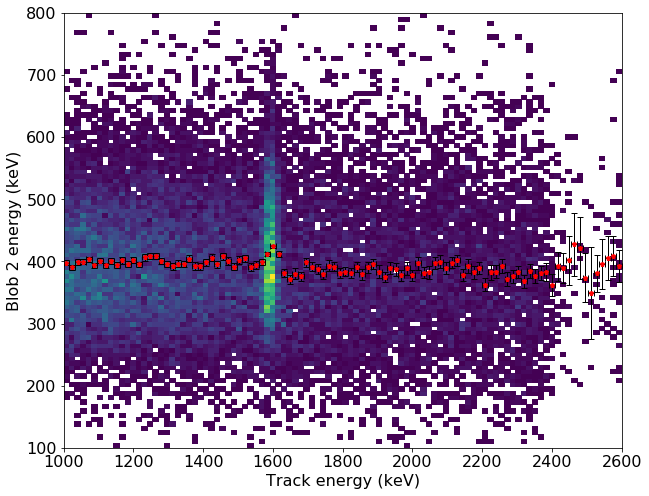

In [30]:
fig = plt.figure(1);
fig.set_figwidth(10.);
fig.set_figheight(8.);

xrange = (1000, 2600)
yrange = (100, 800)
xbins = 100

_, _, _, _ = plt.hist2d(energy_all, e_blob1_all, bins=(xbins, xbins), \
                        range=(xrange, yrange), cmin=1)

x, y, yu = fitf.profileX(energy_all, e_blob1_all, xbins, xrange=xrange, drop_nan=False)
plt.errorbar(x, y, yu, np.diff(x)[0]/2, fmt="rp", ms=5, lw=1, ecolor='black', \
             capsize=3)

plt.xlabel('Track energy (keV)')
plt.ylabel('Blob 2 energy (keV)')

Text(0, 0.5, 'Counts/bin')

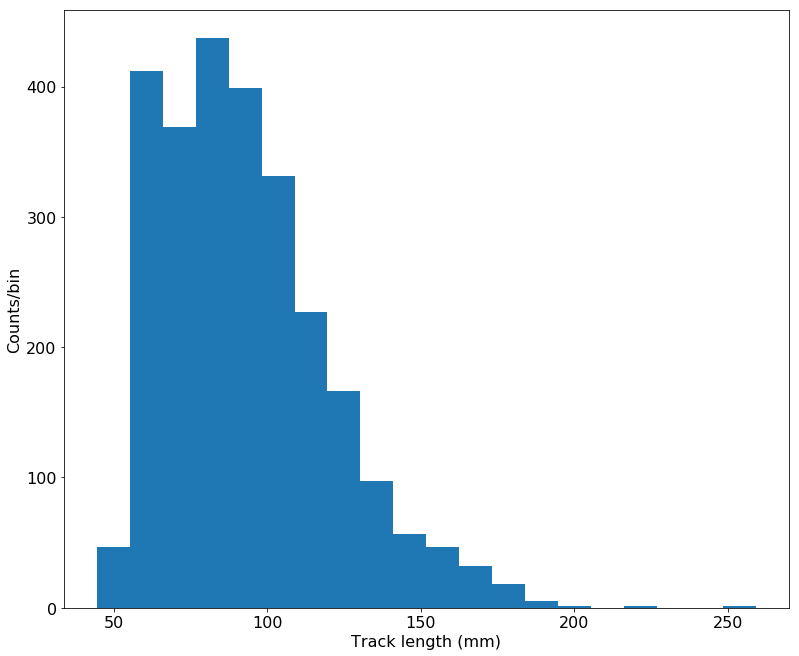

In [31]:
_, _, _ = plt.hist(length, bins=20);
plt.xlabel('Track length (mm)')
plt.ylabel('Counts/bin')

## Summary table plots

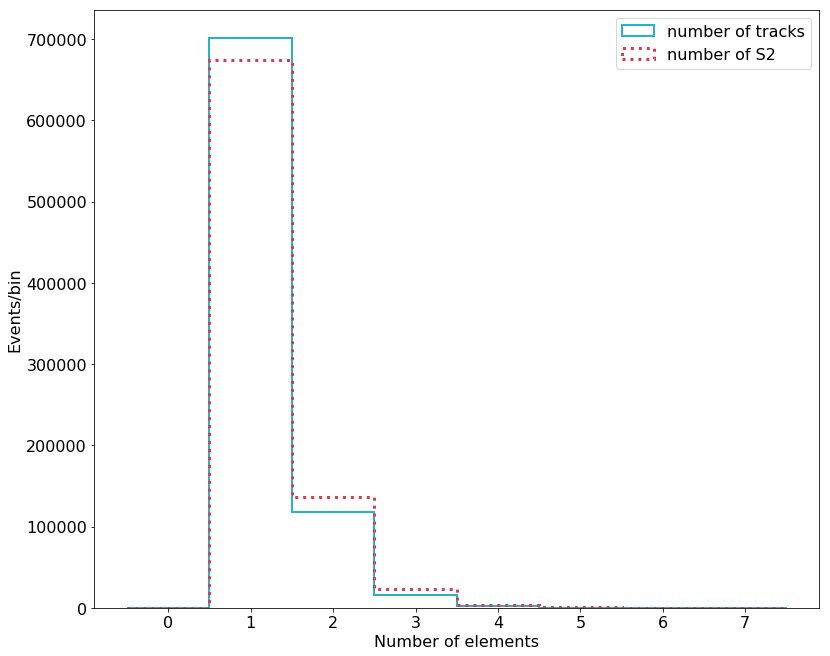

In [32]:
min_plot = -0.5
max_plot = 7.5
nbins = int(max_plot - min_plot)

n_tracks = summary.ntrks
n_S2 = summary.nS2

bins = np.histogram(np.hstack((n_tracks, n_S2)), bins=nbins)[1] # get the bin edges

plt.hist(n_tracks,  label='number of tracks', color=light_blue, range = (min_plot, max_plot),
          bins = nbins, histtype='step', stacked=True, fill=False, linewidth=2.0)
plt.hist(n_S2,    label='number of S2', color=fucsia, range = (min_plot, max_plot),
          bins = nbins, histtype='step', stacked=True, fill=False, linewidth=3.0, linestyle=':')

lnd = plt.legend(loc=1)

labels('Number of elements', 'Events/bin', '')